### Simple Sentiment Analysis for Twitter

Using 16,000 tweets directed at or written by the top four 2016 presidential candidates post-Iowa Caucus: Hillary Clinton, Ted Cruz, Bernie Sanders, and Donald Trump, we will create plots to analyze the sentiment of Twitter users related to the four candidates.

### Global parameters 

You will need to have set up a [Karst account](https://kb.iu.edu/d/bezu#account) first. Once you have your Karst account simply go to [rstudio.iu.edu](https://rstudio.iu.edu/auth-sign-in) and login using your IU username and passphrase.  Next, set the working directory by pointing to the location on Karst where you have stored the files. Below, we have chosen to save the folder "Text-Analysis" as a "Project" in R Studio on the Karst super-computer here at Indiana University. It contains the R scripts, texts, notebooks, and results. If you have forked and cloned the Github repository (see [textPrep.Rmd](textPrep.Rmd) for directions on how), simply point to where you have saved the folder. If you save it to your personal Karst folder, it will most likely look very similar to the example below. Karst is a unix server and so the home directory is represented by a ~ and, thus, the path will look like this "~/Text-Analysis/" (with the quotes). Alternatively, if you are on a PC, you will need to use an absolute path such as "C:/Users/XXX" (with the quotes again).

In R Studio, click Session in the menu bar > Set Working Directory > Choose Directory, then select the Text-Analysis directory in which you are working. This will set your working directory in the console pane, but make sure to copy the path into the source pane above to keep the directory constant if you close this script and reopen later. Make sure you click on the blue cube with a "R" in the center to set your working directory to your Text-Analysis project path.

HINT: Your working directory is the folder from which you will be pulling your texts.

In [2]:
setwd("~/Text-Analysis")

#Source Multiplot Function
source("RScripts/multiplot.R")

### Include necessary packages for notebook 

R's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of R, others created by R users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In R Studio, packages can be installed by navigating to Tools in the menu bar > Install Packages. Or in the bottom right panel click on the "packages" tab and then click on "install."

These five packages are used within the sentiment analysis script:

tm - A package for text mining

twitteR - this is a fun little package that allows the user to search twitter for tweets containing certain words/phrases or by certain people, check out [this post](https://themepacific.com/how-to-generate-api-key-consumer-token-access-key-for-twitter-oauth/994/) for information on setting up an API key to access tweets

plyr - this package splits, combines, and applies data (the laply function used below while instantiating the algorithm comes with this package)

stringr - eases string operations (we will use str_split also while instantiating the algorithm, which is included with the stringr package).

ggplot2 - a great package that renders a range of plots to display information, we will use this package to create our ultimate plots


In [3]:
library(tm)
library(twitteR)
library(plyr)
library(stringr)
library(ggplot2)

Loading required package: NLP

Attaching package: ‘plyr’

The following object is masked from ‘package:twitteR’:

    id


Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate



### Load data 

Each .RData object is a curated set of tweets grabbed from Twitter using the TwitteR package. The tweets orginially return as a list, which was then saved as the .RData object you see here. We load the .RData files into our environment using readRDS and save them into a variable we can use later. 

Hint 1: The names of the variables can be anything (happiness, rainbows, cats), but usually, you want to name them using terms to indicate what the variable holds. Here we use clinton.tweets to represent the tweets associated with @HillaryClinton on Twitter, and so on for the others. The period (.) between "clinton" and "tweets" does not serve any purpose other than to separate the two terms for ease of reading. 

Hint 2: Another popular naming convention is to list the type of object with the name, for example clinton.tweets.l since this object is a list. This convention helps when manipulating the data later.

In [4]:
clinton.tweets <- readRDS("data/twitter/tweetsclinton.RData")
cruz.tweets <- readRDS("data/twitter/tweetscruz.RData")
sanders.tweets <- readRDS("data/twitter/tweetssanders.RData")
trump.tweets <- readRDS("data/twitter/tweetstrump.RData")

### Inspect Data

Before preparing the data for analysis, let us first see what we are working with. For tutorial purposes, we will look at the first: clinton.tweets, but feel free to use the same commands to inspect any of the variables we have created. This step is a good idea to ensure you know what you are ultimately analyzing. For example, if you find that the length is zero, you may have to go back and reload or re-grab the data.

Class describes the type of object. In this case, we grabbed tweets using the TwitteR package, which results in a list:

In [5]:
class(clinton.tweets)

[1] "list"

Length shows how many elements the object has. We grabbed 4,000 tweets (specified while using the TwitteR package), so our list is made up of 4,000 elements. An element here is a tweet!

In [6]:
length(clinton.tweets)

[1] 4000

We can also look at individual elements - Lets see what the first (most recent) tweet is...

In [7]:
clinton.tweets[1]

[[1]]
[1] "N0Control07: Coin flip \"wins\" by @HillaryClinton doesn't change how happy I am for @BernieSanders. #NotMeUs #FeelTheBern #Bernie2016"


Or perhaps you would like to see the first few elements:

In [8]:
head(clinton.tweets)

[[1]]
[1] "N0Control07: Coin flip \"wins\" by @HillaryClinton doesn't change how happy I am for @BernieSanders. #NotMeUs #FeelTheBern #Bernie2016"

[[2]]
[1] "ItsAlinajo: @JAPITTER ROFLMAAAAO!! Thanks Jeff! Coins for donors! :-) @DJROBBZ_BLOG @Teddyshouse2II @richdoll54 @YevetteEdwards @Ronc99 @HillaryClinton"

[[3]]
[1] "terryshumaker: @billclinton in Laconia, NH: Progressive reformers in our history like @HillaryClinton get more done #FITN https://t.co/USPhXAEdV3"

[[4]]
[1] "watizy: @CNN @HillaryClinton it looks more like fraud, winning six coin toss. Yeah right."

[[5]]
[1] "Eric_Bailon: RT @RuFreeman: Perspective for the Dems on #IowaCaucusresults  :  ) #Bernie2016 @HillaryClinton @SenateDems @HouseDemocrats https://t.co/77…"

[[6]]
[1] "OhCarouu: RT @HillaryClinton: Text CONGRATS to 47246 to tell Hillary you'll be by her side for the next part of this campaign. https://t.co/FHoAPFiji8"


There are many more ways to inspect parts of data (check out the CRAN), but these quick checks are helpful while manipulating and trimming the data pre-analysis.

### Extract Text

Since we grabbed our data from Twitter, there is metadata included in the tweet list such as retweet, favorite, and reply information. For sentiment analysis, we just need the text. The following line extracts the text from each tweet in the list and saves the new list of just text as [candidate_name].text.

In [9]:
clinton.text = laply(clinton.tweets, function(t) t$getText())
cruz.text = laply(cruz.tweets, function(t) t$getText())
sanders.text = laply(sanders.tweets, function(t) t$getText())
trump.text = laply(trump.tweets, function(t) t$getText())

Now we are all set! Let's load in some postivity (and negativity, I guess...)!

### Loading the Opinion Lexicons to Determine Sentiment

This is an essential step for sentiment analysis. These text documents from Hu and Liu, 2004* are filled with positive and negative words, respectively. The algorithm we will write next will check these documents to score each word in the tweet. If the algorithm runs across the word "love" in a tweet, it will check the positive-words.txt file, find "love" is included, and score the word with a +1. More on that in a second...

In [10]:
lex.pos = scan('data/opinionLexicon/positive-words.txt', what='character', comment.char = ';')
lex.neg = scan('data/opinionLexicon/negative-words.txt', what='character', comment.char = ';')

Add words relevant to our corpus using the combine c() function:

In [11]:
pos.words = c(lex.pos, 'win', 'prove', 'beat', 'endorse', 'endorses', 'exciting', 'vote', 'wins', 'support', 'supports', 'help', 'winner')
neg.words = c(lex.neg, 'outnumbered', 'lose', 'losing', 'defeat', 'halt')

Remove words that might skew the results. Use combine c() function if you have more than one word:

In [12]:
pos.words <- removeWords(pos.words, 'trump')
#neg.words <- removeWords(neg.words, c('issue', 'issues', 'problem', 'problems'))

### Implement the sentiment scoring algorithm

Here is where the magic happens - let's create the algorithm! To begin a function which will iterate over all of the elements in the specified object, we need to give it a name - score.sentiment sounds good. First, we set the name of our function equal to function(). Then, we fill the parenthesis with our arguments. Here, we want an argument for the tweets (our data we gathered), our positive words, and our negative words. 

This function takes in an argument (tweets for us), normalizes all of the text (including removing emojis which is important for tweets), splits the tweets into separate words to analyze, compares the tweet words to the positive and negative dictionaries, returns a TRUE if the word is in the dictionary and FALSE if it is not, the trues and falses are summed up for each tweet (this is the score of the tweet), and finally, the tweet's score and its text are returned as a data frame for ease of plotting.

Hint: You may notice some odd expressions in the first few lines of the scores function: they are called regular expressions (or, regex). Regular expressions allow the user to match on certain patterns throughout the entire text. In this case, we are matching on punctuation, control characters (or invisible, non-printing characters), and digits, in the effort to strip out unnecessary characters that do not provide sentiment valence. Check out [this CRAN page](https://stat.ethz.ch/R-manual/R-devel/library/base/html/regex.html) for more information about using regex in R.

In [13]:
score.sentiment = function(tweets, pos.words, neg.words, .progress='none')
{

  #figure out the score for each tweet specifically
  scores = laply(tweets, function(tweet, pos.words, neg.words) {
    #normalize tweet text
    tweet = gsub('[[:punct:]]', '', tweet)
    tweet = gsub('[[:cntrl:]]', '', tweet)
    tweet = gsub('\\d+', '', tweet)
    
    #REMOVE EMOJIS!
    tweet = iconv(tweet, "ASCII", "UTF-8", sub="")
    
    tweet.lower = tolower(tweet)
    
    #split list into separate words
    word.list = str_split(tweet.lower, '\\s+')
    words = unlist(word.list)
    
    #compare our words to the dictionaries of positive and negative terms using match function
    pos.matches = match(words, pos.words)
    neg.matches = match(words, neg.words)
    
    #match returns a position of the matched term or NA, but we just want the TRUE/FALSE, not NA
    pos.matches = !is.na(pos.matches)
    neg.matches = !is.na(neg.matches)
    
    #the score of each tweet is the sum of the positive matches minus the sum of the negative matches
    score = sum(pos.matches) - sum(neg.matches)
    
    return(score)
  }, pos.words, neg.words, .progress = .progress)
  
  #compile the scores and text of tweets into a data frame for plotting
  scores.df = data.frame(score=scores, text = tweets)
  return(scores.df)
}

### Algorithm Testing

Whenever you create a function (or algorithm), it is best to test it on some sample data to ensure it behaves as you expect. Let's create a sample list of emotional sentences and save it as "sample".


In [14]:
sample = c("This ice cream is the best! I love this flavor!", 
           "I am so angry at the terrible weather today. Frustrated.", 
           "Wow, spectacular, I wish I could be as perfect as you.")

We already did the hard part by building our score.sentiment function earlier. Here, we just need to tell the algorithm what to use as arguments! We need to put our sample data in as the "tweets" argument, pos.words as the "pos.words"" argument, and neg.words as the "neg.words" argument! 

Lets also save the result of running the algorithm as an object called sample.result.

In [15]:
sample.result = score.sentiment(sample, pos.words, neg.words)

Did it work?

In [16]:
sample.result

score,text
2,This ice cream is the best! I love this flavor!
-3,I am so angry at the terrible weather today. Frustrated.
3,"Wow, spectacular, I wish I could be as perfect as you."


It worked! Now we can be sure our algorithm is behaving as we would expect. Lets score our Twitter data since we are confident in our function-creating abilities...

### Scoring Twitter Data

Again, we have already created our function, we just need to tell it what to analyze. We will use our [candidate].text objects as the "tweets" argument and save each as an object called [candidate].result to plot a little later.

In [17]:
clinton.result = score.sentiment(clinton.text, pos.words, neg.words)
cruz.result = score.sentiment(cruz.text, pos.words, neg.words)
sanders.result = score.sentiment(sanders.text, pos.words, neg.words)
trump.result = score.sentiment(trump.text, pos.words, neg.words)

Lets peek at the results to see if it is still working...

In [18]:
tail(clinton.result)

,score,text
3995,1,.@HillaryClinton talks one-on-one w/ @wolfblitzer moments after finding out she won in #Iowa https://t.co/fUFppUa7v3 https://t.co/3rWCziutyg
3996,1,"RT @CNN: She's 102 years old, and she was at the #IowaCaucus to support @HillaryClinton https://t.co/yhvlaTbKQI https://t.co/IIx2rxm6fq"
3997,1,RT @ChloeGMoretz: My girl won Iowa !!!!!! @HillaryClinton
3998,-2,RT @UniteWomenWY: .@BernieSanders' #BernieBros Problem. His crusaders who hate on @HillaryClinton supporters https://t.co/wRsZzC2KYI
3999,0,RT @HillaryClinton: Text CONGRATS to 47246 to tell Hillary you'll be by her side for the next part of this campaign. https://t.co/FHoAPFiji8
4000,0,RT @HillaryClinton: Text CONGRATS to 47246 to tell Hillary you'll be by her side for the next part of this campaign. https://t.co/FHoAPFiji8


In [19]:
tail(cruz.result)

,score,text
3995,-1,"Lol, @jaketapper just called @marcorubio the ""Democrat that the Clinton machine fears most."" @tedcruz campaign already drafting mailers."
3996,2,@tedcruz @HillaryClinton . I can't wait too! You'll do awesome! #TrusTed #CruznwithTed #TedCruz
3997,0,It's @realDonaldTrump vs. @tedcruz for the #2016 #GOP race. @elainaplott of @NRO discusses w/@News8NewsTalk: https://t.co/kTa99SSoa6
3998,-1,RT @theblaze: .@tedcruz apologizes to @RealBenCarson for campaign rumor that made waves in Iowa: https://t.co/VHpiRxrEZs
3999,-1,@SenTedCruz @tedcruz You want to win by cheating and being dishonest? You are just a Democrat and managed to piss us off.
4000,0,"RT @AlexSanz: One day after the #IowaCaucus, @TedCruz holds a town hall in Windham, New Hampshire. https://t.co/tJ6SIpTqav"


In [20]:
tail(sanders.result)

,score,text
3995,2,"RT @BernieSanders: In the year 2016, public colleges and universities should be tuition free. How will we pay for it? We're gonna tax Wall …"
3996,1,"RT @BernieSanders: We do not represent the interests of the billionaire class, Wall Street or corporate America. We don't want their money."
3997,0,RT @jhutch1992: #notmeus #Bernie2016 #FeeltheBern #CaucusForBernie @iowastateu @BernieSanders @roytatem @fosterthepeople https://t.co/iQN2…
3998,0,"RT @caitlinstasey: YOUNG DEMOCRATS, U HAV TH ABILITY 2 DRAMATICALLY EFFECT THIS ELECTION! #FeelTheBern @ShaunKing @BernieSanders VOTE http…"
3999,1,@CNNSitRoom @HillaryClinton @CNNPolitics Actually @BernieSanders has the leverage for additional debates.
4000,0,"RT @BernieSanders: Last night, we began the political revolution not just in Iowa, not just in New Hampshire but all over this nation. http…"


In [21]:
tail(trump.result)

,score,text
3995,1,"RT @DiamondandSilk: We are Americans. We Stand Together, United! https://t.co/9ftoKhKVqe to vote for @realDonaldTrump in the Primary #S…"
3996,2,RT @IngrahamAngle: The #CruzCrew prevailed! Smart for @MarcoRubio to keep his speech short &amp; sweet. Ditto for @realDonaldTrump who was brie…
3997,1,"Proud of @SophiaMosh 4 announcing herself as delegate in Ffx, VA. @realDonaldTrump u wnt her on ur team! #Trump2016 https://t.co/zY8l4Li11y"
3998,0,@realDonaldTrump my teacher said you had a book signing in florida and only 3 people came
3999,1,RT @realDonaldTrump: On my way to New Hampshire- expecting a big and spirited crowd! #FITN #Trump2016 https://t.co/oUg1ErD0j7 https://t.c…
4000,0,@cbcsteve @CBCNews @realDonaldTrump Time to buy a farm out there Donald!!


### Plotting Twitter Data

To visualize the sentiment of these particular tweets, we will use the plotting system ggplot2 and its quick plot (qplot) functionality. The qplot function takes an object, which is the score from our tweets, then you can specify other parts of the plot. For example, we have titled our plots "Sentiment of [candidate's twitter handle] on Twitter," labeled the x-axis "Valence of Sentiment (Tweet Score)," and labeled the y-axis "Count (Tweets)." These were all saved as [candidate].plot objects to use later.

Below, we impose the "Black and White" theme on the plots


Loading required package: grid
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

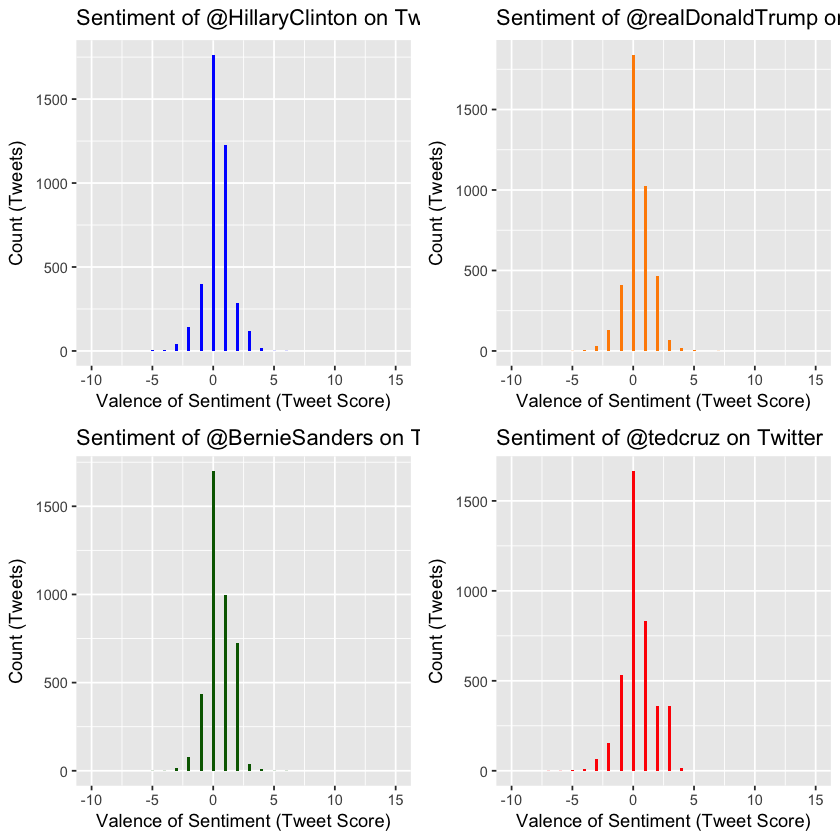

In [22]:
# Plotting Twitter Data
clinton.plot = qplot(clinton.result$score, fill=I("blue"), xlim=(c(-10,15)), 
                     main = "Sentiment of @HillaryClinton on Twitter", 
                     xlab= "Valence of Sentiment (Tweet Score)", ylab="Count (Tweets)", binwidth = .25) 
cruz.plot = qplot(cruz.result$score, fill=I("red"), xlim=(c(-10,15)),
                  main = "Sentiment of @tedcruz on Twitter",
                  xlab= "Valence of Sentiment (Tweet Score)", ylab="Count (Tweets)",binwidth = .25)
sanders.plot = qplot(sanders.result$score, fill=I("darkgreen"), xlim=(c(-10,15)),
                    main = "Sentiment of @BernieSanders on Twitter", 
                    xlab= "Valence of Sentiment (Tweet Score)", ylab="Count (Tweets)", binwidth = .25)
trump.plot = qplot(trump.result$score, fill=I("darkorange"), xlim=(c(-10,15)),
                   main = "Sentiment of @realDonaldTrump on Twitter", 
                   xlab= "Valence of Sentiment (Tweet Score)", ylab="Count (Tweets)", binwidth = .25)




multiplot(clinton.plot, sanders.plot, trump.plot, cruz.plot, cols=2)

### Voila!

Acknowledgements: This algorithm was adapted from Jeffrey Breen's Mining Twitter for Airline Consumer Sentiment article. You can find it here: http://www.inside-r.org/howto/mining-twitter-airline-consumer-sentiment. 

Reference: Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing and Comparing Opinions on the Web." Proceedings of the 14th International World Wide Web conference (WWW-2005), May 10-14, 2005, Chiba, Japan.